In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import torch
a = torch.ones((10,10), device='cuda')
for i in a:
    print(i)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


In [11]:
import sys
import os
py_file_location = "/home/chizm/PatchART/pgd"
sys.path.append(os.path.abspath(py_file_location))

In [4]:
cd './gdrive/My Drive/PGD'

/content/gdrive/My Drive/PGD


In [5]:
!pwd

/content/gdrive/My Drive/PGD


In [13]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
# import matplotlib.pyplot as plt
import numpy as np

In [14]:
!nvidia-smi

Sun Sep 17 12:20:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P8    15W /  N/A |   3083MiB /  8192MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [16]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.version.cuda)

True
0
11.7


In [17]:
class PGD():
  def __init__(self,model,eps=0.3,alpha=2/255,steps=40,random_start=True):
    self.eps = eps
    self.model = model
    self.attack = "Projected Gradient Descent"
    self.alpha = alpha
    self.steps = steps
    self.random_start = random_start
    self.supported_mode = ["default"]
  
  def forward(self,images,labels):
    images = images.clone().detach()
    labels = labels.clone().detach()


    loss = nn.CrossEntropyLoss()

    adv_images = images.clone().detach()

    if self.random_start:
        adv_images = adv_images + torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

    for step in range(self.steps):
        adv_images.requires_grad = True
        outputs = self.model(adv_images)
        cost = loss(outputs, labels)
        grad = torch.autograd.grad(cost, adv_images,retain_graph=False, create_graph=False)[0]

        adv_images = adv_images.detach() + self.alpha*grad.sign()
        delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()

    return adv_images

In [18]:
class NeuralNet(nn.Module):
  def __init__(self):
      super(NeuralNet,self).__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
      self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
      self.maxpool = nn.MaxPool2d(2)
      self.relu = nn.ReLU()
      self.fc1 = nn.Linear(1024, 32)
      self.fc2 = nn.Linear(32, 10)

  def forward(self,x):
      x = self.conv1(x)
      x = self.maxpool(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.maxpool(x)
      x = self.relu(x)
      # x = torch.flatten(x, 1)
      x = x.view(-1,1024)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      # x = torch.sigmoid(x)
      return x

In [8]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet,self).__init__()
    # self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    # self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    # self.maxpool = nn.MaxPool2d(2)
    
    self.relu = nn.ReLU()
    # self.fc1 = nn.Linear(1024, 10)
    self.fc1 = nn.Linear(28 * 28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 10)


  def forward(self,x):
    x = x.view(-1, 28 * 28)
    # x = self.conv1(x)
    # x = self.maxpool(x)
    # x = self.relu(x)
    # x = self.conv2(x)
    # x = self.maxpool(x)


    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.fc5(x)
    # x = torch.flatten(x, 1)
    # x = x.view(-1,1024)
    # x = self.fc1(x)
    x = F.softmax(x)
    return x

In [19]:
train = datasets.MNIST('./data/', train=True,
                       transform=transforms.Compose([transforms.ToTensor(),]),
                       download=True)
train_loader = DataLoader(train, batch_size=128)

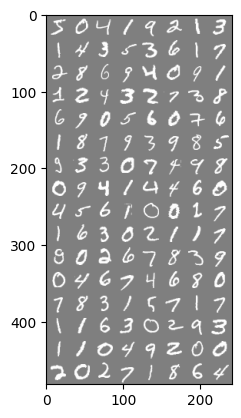

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4])


In [9]:
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(labels)

In [20]:
model = NeuralNet()
print("Model structure: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure:  NeuralNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
) 


Layer: conv1.weight | Size: torch.Size([32, 1, 5, 5]) | Values : tensor([[[[ 0.0301,  0.1148,  0.0857, -0.1535, -0.1709],
          [ 0.0090, -0.0795, -0.0470,  0.0338, -0.1562],
          [ 0.0135, -0.0313,  0.0872, -0.1918,  0.1929],
          [-0.0688,  0.0428, -0.0387, -0.1700,  0.0141],
          [-0.1125,  0.0275, -0.0729,  0.0285,  0.0004]]],


        [[[-0.0690, -0.0207, -0.0927,  0.1127,  0.1380],
          [ 0.0027, -0.0269,  0.1609,  0.1916, -0.1796],
          [-0.1784, -0.0290,  0.1040, -0.0195, -0.1049],
          [-0.1336,  0.1322,  0.0132,  0.0913,  0.0558],
          [-0.1881,  0.1538, -0.0265

In [23]:
model.train()
optimiser = optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [24]:
for epoch in range(10):
  epoch_loss = 0
  correct, total = 0,0
  for i,data in enumerate(train_loader,0):
    inputs,labels = data
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs,labels)
    loss.backward()
    optimiser.step()
    epoch_loss += loss.item()
    pred = torch.max(outputs,1)
    total += labels.size(0)
    correct += (pred.indices == labels).sum().item()
  print("Epoch:",epoch+1, " Loss: ",epoch_loss," Accuracy:",correct/total)

Epoch: 1  Loss:  1079.2617967128754  Accuracy: 0.11236666666666667
Epoch: 2  Loss:  1079.26034283638  Accuracy: 0.11236666666666667
Epoch: 3  Loss:  1079.2590281963348  Accuracy: 0.11236666666666667
Epoch: 4  Loss:  1079.2578434944153  Accuracy: 0.11236666666666667
Epoch: 5  Loss:  1079.256744146347  Accuracy: 0.11236666666666667
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/chizm/miniconda3/envs/PatchART/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_10071/741556056.py", line 4, in <module>
    for i,data in enumerate(train_loader,0):
  File "/home/chizm/miniconda3/envs/PatchART/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 628, in __next__
  File "/home/chizm/miniconda3/envs/PatchART/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 671, in _next_data
    self._dataset, self._world_size, self._rank, sharding_group=SHARDING_PRIORITIES.DISTRIBUTED)
  File "/home/chizm/miniconda3/envs/PatchART/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
  File "/home/chizm/miniconda3/envs/PatchART/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
  File "/home/chizm/miniconda3/envs/PatchART/lib/python3.8/

In [13]:
os.makedirs('./model',exist_ok=True)

In [14]:
torch.save(model.state_dict(), './model/pdg_net.pth')

In [25]:
model.load_state_dict(torch.load('./model/pdg_net.pth'))

<All keys matched successfully>

In [30]:
test = torch.load('/home/chizm/PatchART/data/MNIST/processed/test_norm00.pt')
test_loader = DataLoader(test, batch_size=128)


In [33]:
model.eval()
correct = 0
iter_test = iter(test_loader)
import math
train_nbatch = math.ceil(10000/128)
for i in range(train_nbatch):
    inputs,labels = iter_test.__next__()
    data, target = inputs.to(device), labels.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/chizm/miniconda3/envs/PatchART/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_10071/337312490.py", line 7, in <module>
    inputs,labels = iter_test.__next__()
  File "/home/chizm/miniconda3/envs/PatchART/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 628, in __next__
  File "/home/chizm/miniconda3/envs/PatchART/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 671, in _next_data
    self._dataset, self._world_size, self._rank, sharding_group=SHARDING_PRIORITIES.DISTRIBUTED)
  File "/home/chizm/miniconda3/envs/PatchART/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 61, in fetch
  File "/home/chizm/miniconda3/envs/PatchART/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
  File "/home/chizm/miniconda3/envs/PatchART/lib/python

In [16]:
di = iter(train_loader)
sample_images, sample_labels = di.next()

with torch.no_grad():
  op = model(sample_images)
  _,p = torch.max(op.data, dim = 1)
  print(p.shape,sample_labels.shape,sample_images.shape)

torch.Size([128]) torch.Size([128]) torch.Size([128, 1, 28, 28])


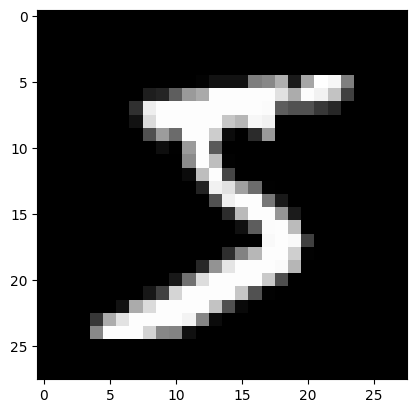

Actual Label: 5 Predicted Label: 5



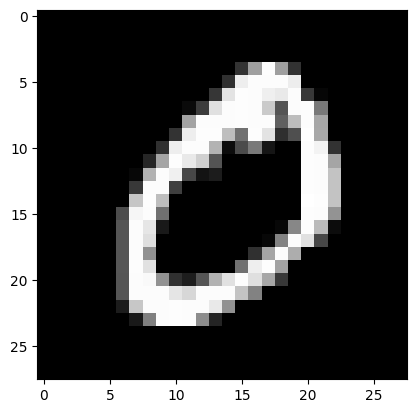

Actual Label: 0 Predicted Label: 0



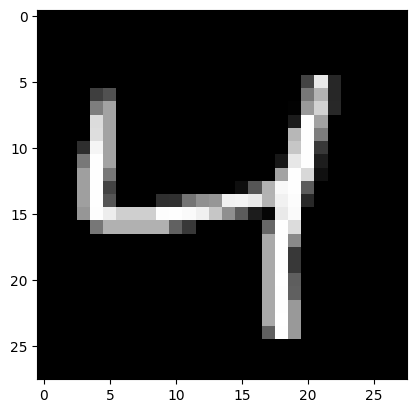

Actual Label: 4 Predicted Label: 4



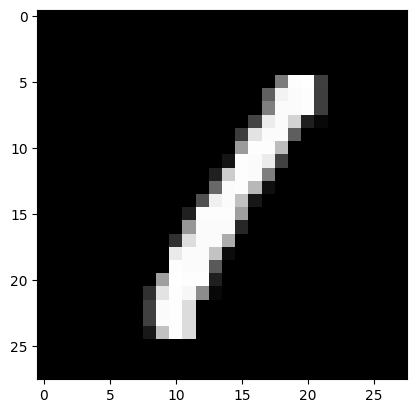

Actual Label: 1 Predicted Label: 1



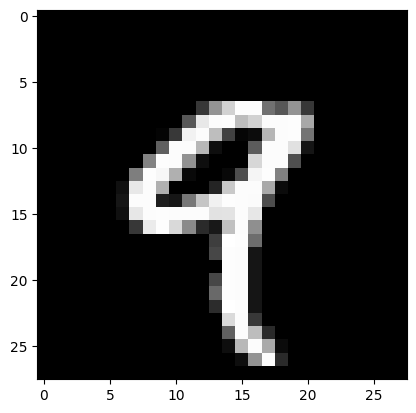

Actual Label: 9 Predicted Label: 9



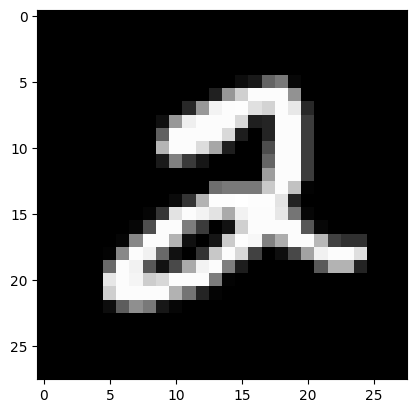

Actual Label: 2 Predicted Label: 2



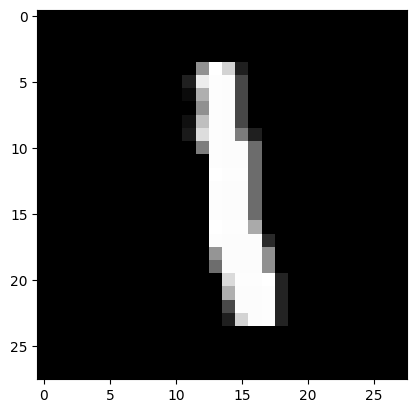

Actual Label: 1 Predicted Label: 1



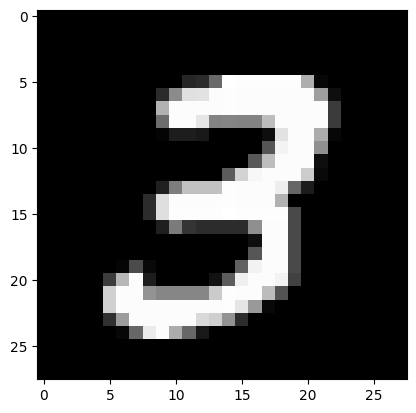

Actual Label: 3 Predicted Label: 3



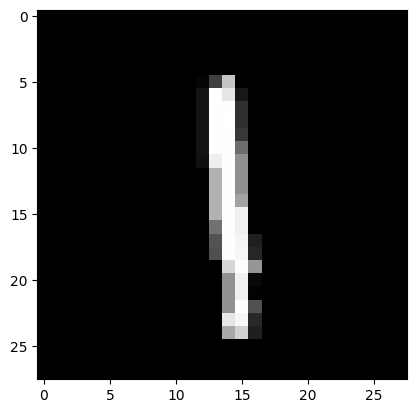

Actual Label: 1 Predicted Label: 1



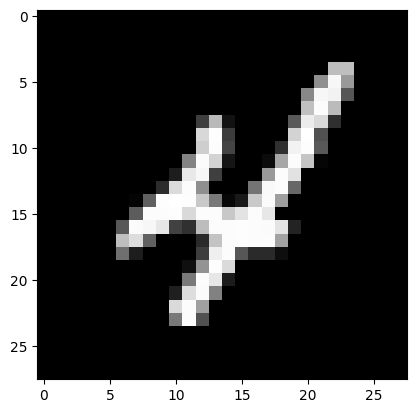

Actual Label: 4 Predicted Label: 4



In [17]:
count = 0
for img,y,y_pred in zip(sample_images,sample_labels,p):
  mg = img / 2 + 0.5  
  npimg = img.numpy()
  plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))),cmap='gray')
  plt.show()
  count += 1
  print("Actual Label:", int(y), "Predicted Label:", int(y_pred))
  print()
  if(count>=10):
    break

In [18]:
iter_attack = iter(train_loader)
atk_images, atk_labels = iter_attack.next()
pgd = PGD(model = model)
x_adv = pgd.forward(atk_images,atk_labels)
adv_op = model(x_adv)
_,p_adv = torch.max(adv_op, dim = 1)

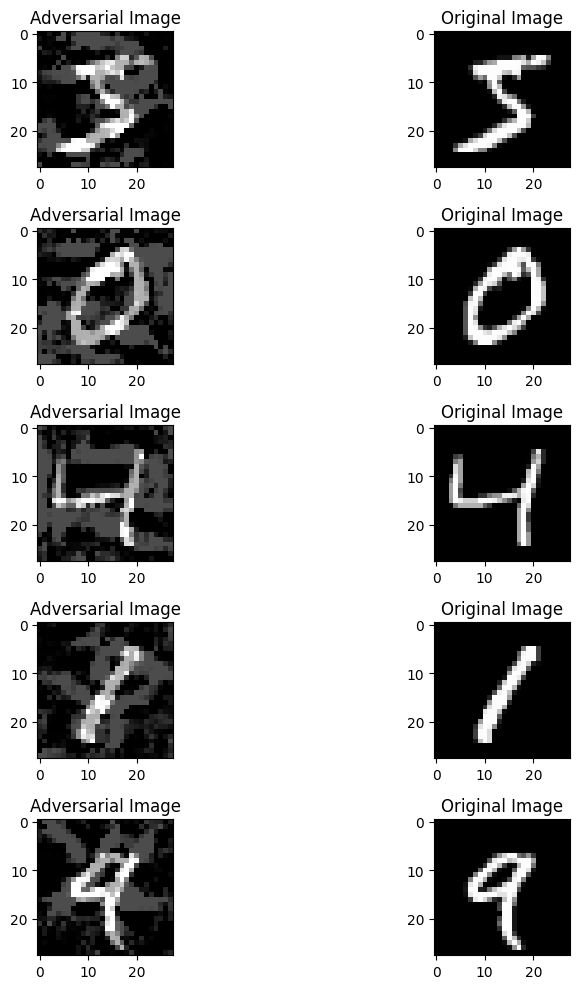

In [19]:
f, axarr = plt.subplots(5,2,figsize=(10,10))
for i,img in enumerate(zip(x_adv,atk_images)):
  img1,img2 = img
  img1,img2 = img1 / 2 + 0.5, img2/2 + 0.5  
  npimg1,npimg2 = img1.numpy(),img2.numpy()
  axarr[i,0].imshow(np.squeeze(np.transpose(npimg1, (1, 2, 0))),cmap='gray')
  axarr[i, 0].set_title("Adversarial Image")
  axarr[i,1].imshow(np.squeeze(np.transpose(npimg2, (1, 2, 0))),cmap='gray')
  axarr[i,1].set_title("Original Image")
  if(i>=4):
    break
f.tight_layout()
plt.show()

In [20]:
adv_pred = torch.max(adv_op,1)
correct = (adv_pred.indices == atk_labels).sum()
total = len(adv_op)
print(int(correct),total)
print("Accuracy after PGD attack:",(int(correct)/total))

0 128
Accuracy after PGD attack: 0.0


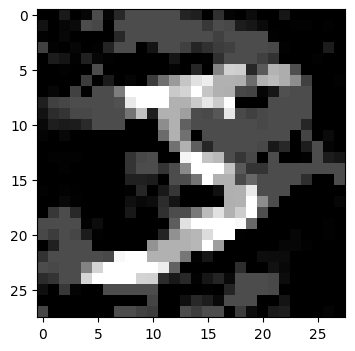

Actual Label: 5 Predicted Label: 3



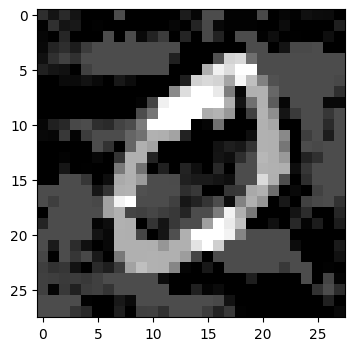

Actual Label: 0 Predicted Label: 2



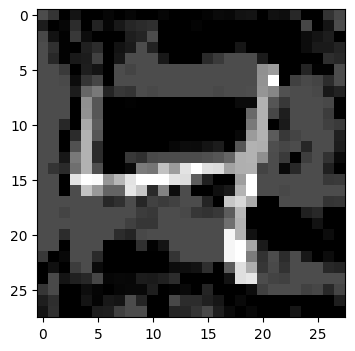

Actual Label: 4 Predicted Label: 2



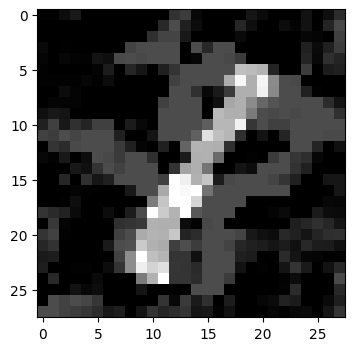

Actual Label: 1 Predicted Label: 8



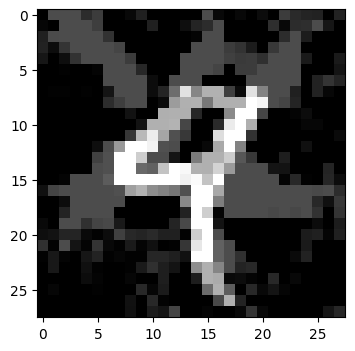

Actual Label: 9 Predicted Label: 4



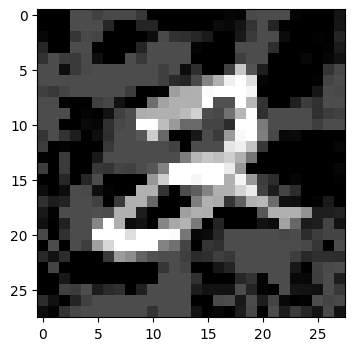

Actual Label: 2 Predicted Label: 3



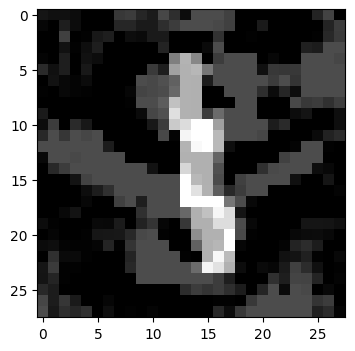

Actual Label: 1 Predicted Label: 8



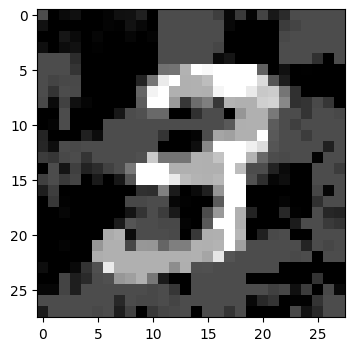

Actual Label: 3 Predicted Label: 9



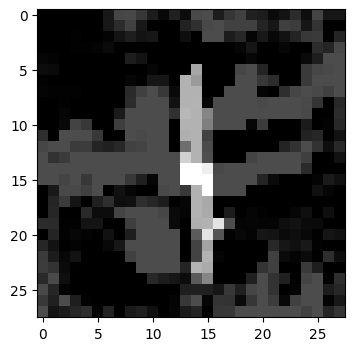

Actual Label: 1 Predicted Label: 8



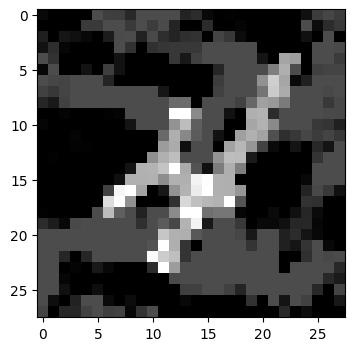

Actual Label: 4 Predicted Label: 8



In [21]:
count = 0
plt.rcParams["figure.figsize"] = (4,4)
for img,y,y_pred in zip(x_adv,atk_labels,adv_pred.indices):
  img = img / 2 + 0.5  
  npimg = img.numpy()
  plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))),cmap='gray')
  plt.show()
  count += 1
  print("Actual Label:", int(y), "Predicted Label:", int(y_pred))
  print()
  if(count>=10):
    break

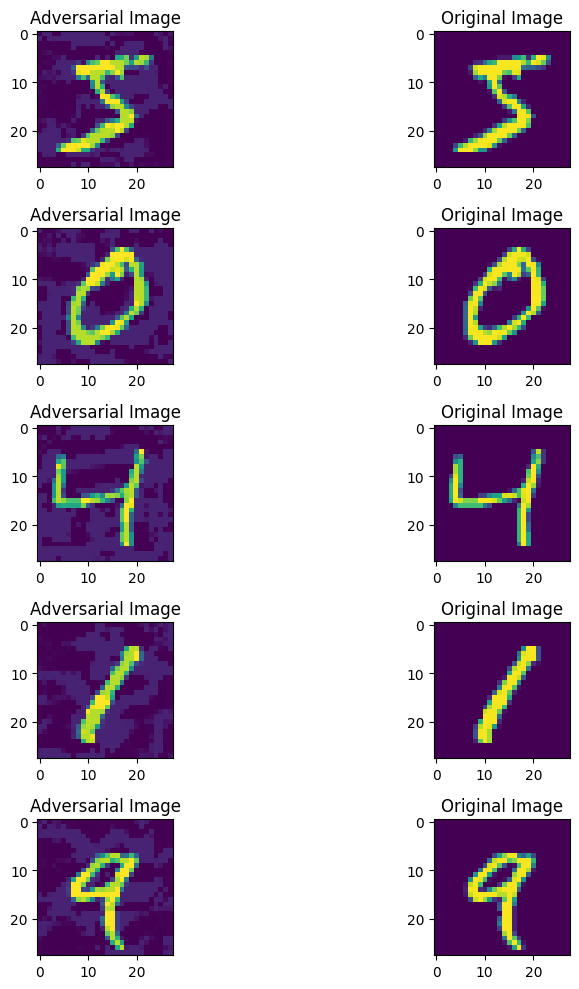

100 128
Accuracy after PGD attack: 0.78125


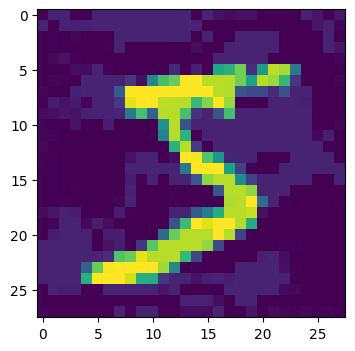

Actual Label: 5 Predicted Label: 3



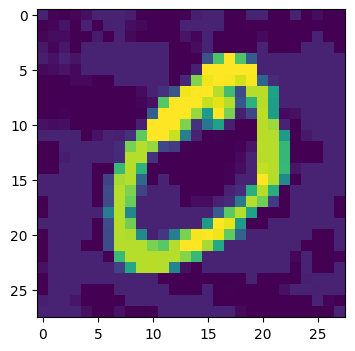

Actual Label: 0 Predicted Label: 0



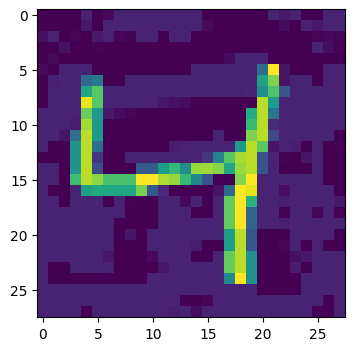

Actual Label: 4 Predicted Label: 4



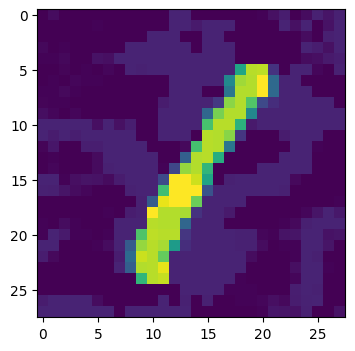

Actual Label: 1 Predicted Label: 1



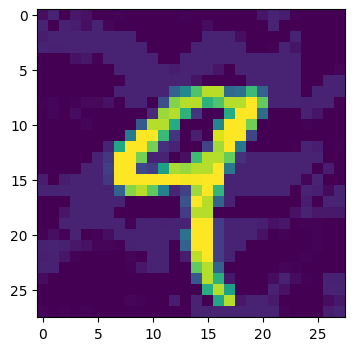

Actual Label: 9 Predicted Label: 4



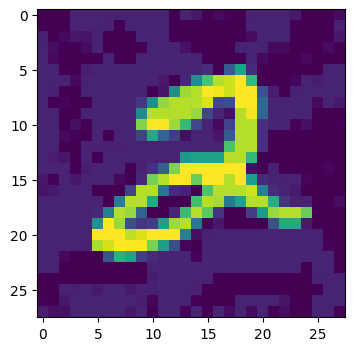

Actual Label: 2 Predicted Label: 2



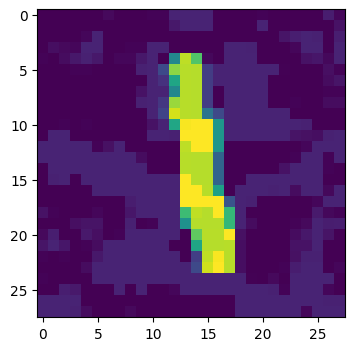

Actual Label: 1 Predicted Label: 1



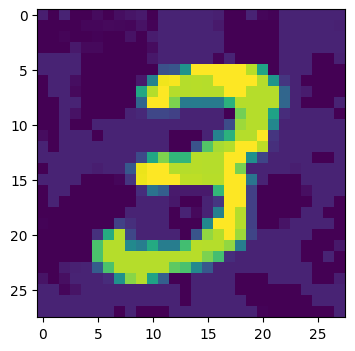

Actual Label: 3 Predicted Label: 3



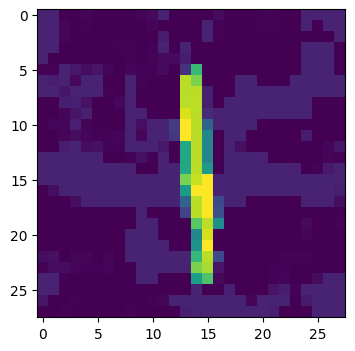

Actual Label: 1 Predicted Label: 1



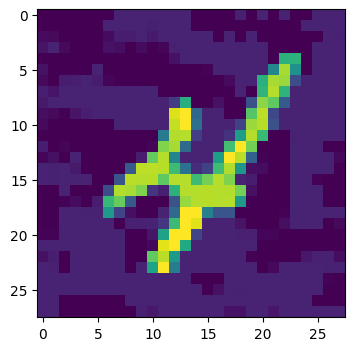

Actual Label: 4 Predicted Label: 4



In [22]:
iter_attack = iter(train_loader)
atk_images, atk_labels = iter_attack.next()
pgd = PGD(model = model,eps = 0.1)
x_adv = pgd.forward(atk_images,atk_labels)
adv_op = model(x_adv)
_,p_adv = torch.max(adv_op, dim = 1)
f, axarr = plt.subplots(5,2,figsize=(10,10))
for i,img in enumerate(zip(x_adv,atk_images)):
  img1,img2 = img
  img1,img2 = img1 / 2 + 0.5, img2/2 + 0.5  
  npimg1,npimg2 = img1.numpy(),img2.numpy()
  axarr[i,0].imshow(np.squeeze(np.transpose(npimg1, (1, 2, 0))))
  axarr[i, 0].set_title("Adversarial Image")
  axarr[i,1].imshow(np.squeeze(np.transpose(npimg2, (1, 2, 0))))
  axarr[i,1].set_title("Original Image")
  if(i>=4):
    break
f.tight_layout()
plt.show()
adv_pred = torch.max(adv_op,1)
correct = (adv_pred.indices == atk_labels).sum()
total = len(adv_op)
print(int(correct),total)
print("Accuracy after PGD attack:",(int(correct)/total))
count = 0
plt.rcParams["figure.figsize"] = (4,4)
for img,y,y_pred in zip(x_adv,atk_labels,adv_pred.indices):
  img = img / 2 + 0.5  
  npimg = img.numpy()
  plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))))
  plt.show()
  count += 1
  print("Actual Label:", int(y), "Predicted Label:", int(y_pred))
  print()
  if(count>=10):
    break

In [ ]:
iter_attack = iter(train_loader)
atk_images, atk_labels = iter_attack.next()
pgd = PGD(model = model)
x_adv = pgd.forward(atk_images,atk_labels)
adv_op = model(x_adv)
_,p_adv = torch.max(adv_op, dim = 1)

In [27]:
train_set = torch.load('./data/MNIST/processed/training.pt',map_location=device)
test_set = torch.load('./data/MNIST/processed/test.pt',map_location=device)
print(train_set[0].shape,train_set[1].shape)
print(test_set[0].shape,test_set[1].shape)

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])


In [40]:
train_DataLoader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)
test_DataLoader = torch.utils.data.DataLoader(test_set,batch_size=16,shuffle=True)

train_iter_attack = iter(train_DataLoader)
test_iter_attack = iter(test_DataLoader)
train_attacked_data = []
train_labels = []
test_attacked_data = []
test_labels = []

In [41]:
for k in train_iter_attack:
    train_attacked_data.append(k[0])
    train_labels.append(k[1])

RuntimeError: stack expects each tensor to be equal size, but got [60000] at entry 0 and [60000, 28, 28] at entry 1

In [38]:
train_iter_attack

TypeError: '_SingleProcessDataLoaderIter' object is not subscriptable

In [39]:
train_DataLoader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)
test_DataLoader = torch.utils.data.DataLoader(test_set,batch_size=16,shuffle=True)

# train_iter_attack = iter(train_DataLoader)
# test_iter_attack = iter(test_DataLoader)
train_attacked_data = []
train_labels = []
test_attacked_data = []
test_labels = []
# i = 0
# for atk_images, atk_labels in train_iter_attack:
for i,data in enumerate(train_DataLoader,0):
    atk_images, atk_labels = data
    pgd = PGD(model = model)
    x_adv = pgd.forward(atk_images,atk_labels)
    adv_op = model(x_adv)
    _,p_adv = torch.max(adv_op, dim = 1)
    if torch.all(atk_labels != p_adv):
        print(f"train attack success {i}")
        train_attacked_data.append(x_adv)
        train_labels.append(atk_labels)

train_attack_data = torch.cat(train_attacked_data)
train_attack_labels = torch.cat(train_labels)

torch.save((train_attack_data,train_attack_labels),'./data/MNIST/processed/train_attack_data.pt')
# i = 0
for i,data in enumerate(test_DataLoader,0):
    atk_images, atk_labels = data
    pgd = PGD(model = model)
    x_adv = pgd.forward(atk_images,atk_labels)
    adv_op = model(x_adv)
    _,p_adv = torch.max(adv_op, dim = 1)
    if torch.all(atk_labels != p_adv):
        print(f"test attack success {i}")
        test_attacked_data.append(x_adv)
        test_labels.append(atk_labels)

test_attack_data = torch.cat(test_attacked_data)
test_attack_labels = torch.cat(test_labels)

torch.save((test_attack_data,test_attack_labels),'./data/MNIST/processed/test_attack_data.pt')


    





RuntimeError: stack expects each tensor to be equal size, but got [60000] at entry 0 and [60000, 28, 28] at entry 1

In [12]:
import torch
train_data = torch.load('/home/chizm/PatchART/data/MNIST/processed/train_attack_data_part.pt')

flag = (torch.all(train_data[0] >= 0) )
print( flag)

tensor(True, device='cuda:0')


In [27]:
import torch
train_set = torch.load('/home/chizm/PatchART/data/MNIST/processed/training.pt',map_location='cuda:0')
test_set = torch.load('/home/chizm/PatchART/data/MNIST/processed/test_norm00.pt',map_location='cuda:0')


In [28]:
test_set[0][1]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.4549, 0.4902, 0.6706, 1.0000, 1.0000, 0.5882,
          0.3647, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [8]:
import torch
train_set = torch.load('/home/chizm/PatchART/data/MNIST/processed/train.pt',map_location='cuda:0')

In [9]:
train_set[0][1]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
train = datasets.MNIST('/home/chizm/PatchART/data/', train=True,
                       transform=transforms.Compose([transforms.ToTensor(),]),
                       download=True)
train_loader = DataLoader(train, batch_size=128)

: 

In [7]:
trainset_inputs = []
trainset_labels = []
for i,data in enumerate(train_loader,0):
    # collect batch of data and labels, then save as a tuple
    images, labels = data
    trainset_inputs.append(images)
    trainset_labels.append(labels)
    # print(f"batch {i} done")
trainset_inputs = torch.cat(trainset_inputs)
trainset_labels = torch.cat(trainset_labels)
torch.save((trainset_inputs[:10000],trainset_labels[:10000]),'/home/chizm/PatchART/data/MNIST/processed/train00.pt')
# 但它太大了，有180M
    

In [26]:
import torch
train_set = torch.load('/home/chizm/PatchART/data/MNIST/processed/test_attack_data_full.pt',map_location='cuda:0')
train_set[0].shape

torch.Size([2795, 1, 28, 28])

In [2]:
import torch
ori_set = torch.load('/home/chizm/PatchART/data/MNIST/processed/origin_data_FNN_small_0.3.pt',map_location='cuda:0')
# save 600:999 as ori set
ori_set[0].shape
# torch.save((ori_set[0][600:],ori_set[1][600:]),'/home/chizm/PatchART/data/MNIST/processed/origin_data_FNN_small_0.3.pt')

# repair_set = torch.load('/home/chizm/PatchART/data/MNIST/processed/train_attack_data_full_FNN_small_0.3.pt',map_location='cuda:0')
# # save 600:999 as ori set
# torch.save((repair_set[0][600:],repair_set[1][600:]),'/home/chizm/PatchART/data/MNIST/processed/train_attack_data_full_FNN_small_0.3.pt')

# attack_test_data = torch.load('/home/chizm/PatchART/data/MNIST/processed/test_attack_data_full_FNN_small_0.3.pt',map_location='cuda:0')
# # save 6000:9999 as ori set
# torch.save((attack_test_data[0][6000:],attack_test_data[1][6000:]),'/home/chizm/PatchART/data/MNIST/processed/test_attack_data_full_FNN_small_0.3.pt')


torch.Size([400, 1, 28, 28])

In [27]:
import torch
train_set = torch.load('/home/chizm/PatchART/data/MNIST/processed/train_attack_data_full.pt',map_location='cuda:0')
train_set[0].shape

torch.Size([5705, 1, 28, 28])

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset

# 创建自定义数据集
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

# 创建数据集
data = list(range(100))
dataset = MyDataset(data)

# 创建数据加载器，设置shuffle=True
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 获取DataLoader内部的打乱的索引列表
shuffled_indices = data_loader.sampler.indices

# 打印打乱后的索引列表
print("Shuffled Indices:", shuffled_indices)

AttributeError: 'RandomSampler' object has no attribute 'indices'

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset

# 创建自定义数据集
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

# 创建数据集
data = list(range(100))
dataset = MyDataset(data)

# 创建数据加载器，设置shuffle=True
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 获取打乱的样本顺序
shuffled_order = list(data_loader.batch_sampler)
shuffled_indices = [index for batch in shuffled_order for index in batch]

# 打印打乱后的样本顺序
print("Shuffled Indices:", shuffled_indices)

Shuffled Indices: [1, 31, 9, 75, 30, 93, 44, 26, 83, 16, 21, 97, 41, 32, 85, 46, 7, 55, 80, 58, 98, 61, 84, 6, 52, 40, 89, 74, 66, 71, 24, 4, 72, 82, 64, 59, 0, 90, 33, 5, 18, 56, 3, 37, 87, 57, 76, 91, 48, 81, 51, 94, 67, 19, 99, 34, 65, 53, 63, 70, 47, 15, 13, 38, 68, 8, 28, 54, 14, 23, 20, 73, 96, 60, 50, 69, 22, 79, 86, 25, 11, 62, 27, 36, 17, 35, 88, 45, 10, 92, 2, 39, 43, 49, 29, 78, 77, 12, 42, 95]


In [7]:
shuffled_order[0]

[1,
 31,
 9,
 75,
 30,
 93,
 44,
 26,
 83,
 16,
 21,
 97,
 41,
 32,
 85,
 46,
 7,
 55,
 80,
 58,
 98,
 61,
 84,
 6,
 52,
 40,
 89,
 74,
 66,
 71,
 24,
 4]